# Results summary

| Linear Regression                                               | LightGBM Regressor                                             | Linear Regression + ATgfe                               |
|-----------------------------------------------------------------|----------------------------------------------------------------|---------------------------------------------------------|
| <ul>     <li>10-CV RMSE: 11.13</li><li>Test-data RMSE: 10.38</li><li>r^2: 0.644</li> </ul>             | <ul>     <li>10-CV RMSE: 6.44</li><li>Test-data RMSE: **4.23**</li>     <li>r^2: **0.941**</li> </ul>     | <ul>     <li>10-CV RMSE: **6.00**</li><li>Test-data RMSE: 5.45</li>     <li>r^2: 0.899</li> </ul>         |

# Import packages

In [1]:
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError
from lightgbm import LGBMRegressor
from yellowbrick.datasets import load_concrete

In [2]:
dataset = load_concrete(return_dataset=True)
df = dataset.to_dataframe()
df.head()

,cement,slag,ash,water,splast,coarse,fine,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [3]:
target = 'strength'
X = df.drop(target, axis=1).copy()
numerical_features = X.columns.tolist()
Y = df.loc[:, target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=77)

In [4]:
def display_residual_plot(model):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()  

In [5]:
def prediction_error_plot(model):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(rmse)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Scores: {}'.format(scores))
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [8]:
def score_test_data_for_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('R2: {}'.format(r2_score(y_test, y_pred)))
    print('RMSE: {}'.format(rmse(y_test, y_pred)))

In [9]:
def create_new_model():
    model = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))
    return model

# Using LightGBM

In [10]:
lgbm_model = LGBMRegressor(n_estimators=100, random_state=7)

In [11]:
score_model(lgbm_model, X, Y)

Scores: [7.70720917 8.81705692 6.11556869 9.92408539 7.73493099 6.23830488
 4.47530895 6.87590753 3.16376337 3.35459845]
Mean of metric: 6.440673433553295, std: 2.133572203780573


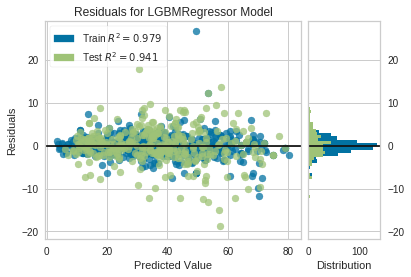

In [12]:
display_residual_plot(lgbm_model)

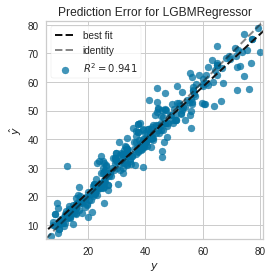

In [13]:
prediction_error_plot(lgbm_model)

In [14]:
score_test_data_for_model(lgbm_model, X_test, y_test)

R2: 0.9407891466518526
RMSE: 4.234409371214675


# Using Logistic Regression

In [15]:
model = create_new_model()

In [16]:
score_model(model, X, Y)

Scores: [17.63146783 13.18801292  9.79119291 13.16377328 11.6197809  11.28616186
  9.38509766  9.05052291  8.22485913  7.99539773]
Mean of metric: 11.13362671274308, std: 2.798781230056411


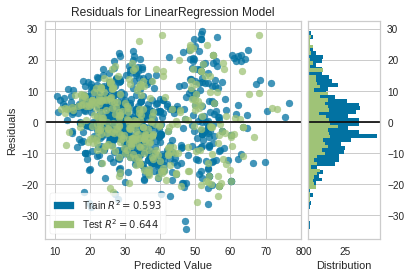

In [17]:
display_residual_plot(model)

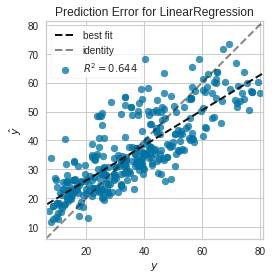

In [18]:
prediction_error_plot(model)

In [19]:
score_test_data_for_model(model, X_test, y_test)

R2: 0.644051839790293
RMSE: 10.382108382047429


# Using ATgfe

In [20]:
model = create_new_model()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

In [22]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=numerical_features,
                             number_of_candidate_features=18,
                             number_of_interacting_features=4,
                             evaluation_metric=rmse, n_jobs=62,
                             cross_validation_in_objective_func=True, objective_func_cv=3)

2019-11-28 02:12:49,631:INFO: New Engineer created with the following parameters: 
2019-11-28 02:12:49,632:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
Number of candidate features: 18
Number of interacting features: 4
Evaluation Metric: rmse
Minimize metric is True 


In [23]:
np_sqrt = np.sqrt
gfe.add_transformation_operation('np_sqrt', np_sqrt)

In [24]:
np_min = np.min
gfe.add_transformation_operation('np_min', np_min)

In [25]:
np_max = np.max
gfe.add_transformation_operation('np_max', np_max)

In [26]:
np_mean = np.mean
gfe.add_transformation_operation('np_mean', np_mean)

In [27]:
gfe.fit(mu=2000, lambda_=2100, early_stopping_patience=10, mutation_probability=0.2, crossover_probability=0.8)

Start of evolution
   	      	                                                    fitness                                                    
   	      	---------------------------------------------------------------------------------------------------------------
gen	nevals	avg      	best_val_score	gen	gen_val_score	max  	min    	nevals	std        	time_in_seconds
0  	2000  	8.975e+10	nan           	0  	nan          	1e+11	6.54837	2000  	3.03305e+10	nan            
1  	2100  	9.45e+09 	6.58041       	1  	6.58041      	1e+11	6.73256	2100  	2.92523e+10	6.76826        
2  	2100  	6.7354   	6.58041       	2  	6.72383      	7.02256	6.43241	2100  	0.103913   	15.5924        
3  	2100  	6.51591  	6.46428       	3  	6.46428      	6.78426	6.28971	2100  	0.0895153  	15.9475        
4  	2100  	6.3772   	6.34758       	4  	6.34758      	6.56692	6.22092	2100  	0.0611532  	15.962         
5  	2100  	6.27841  	6.26754       	5  	6.26754      	6.42613	6.15616	2100  	0.0446767  	16.4333        
6  	21

In [28]:
X = gfe.transform(X)

In [29]:
model = create_new_model()

In [30]:
score_model(model, X, Y)

Scores: [6.63955187 6.5189106  4.87400067 7.78076731 6.69047461 6.81750041
 3.73332356 5.22907125 6.01489662 5.78830541]
Mean of metric: 6.008680229577148, std: 1.0972146479053828


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

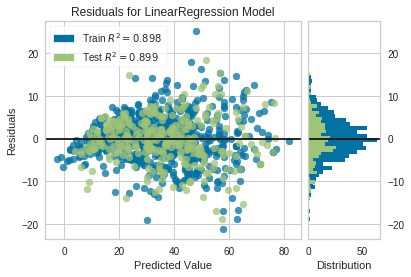

In [32]:
display_residual_plot(model)

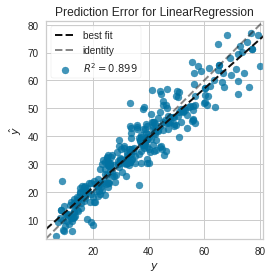

In [33]:
prediction_error_plot(model)

In [34]:
score_test_data_for_model(model, X_test, y_test)

R2: 0.8988555946540859
RMSE: 5.451550363374272
